<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SB3" data-toc-modified-id="SB3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SB3</a></span></li></ul></div>

In [1]:
from config import *
from env import MultiFF
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import ffmpeg
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib import rc, cm
import pandas as pd
import math
from math import pi
import collections
import re
import os, sys
from os.path import exists
import csv
from contextlib import contextmanager
from scipy.signal import decimate
import torch
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
from random import randint
from IPython.display import HTML

## for running RL agents
import gym
from gym import spaces, Env
from gym.spaces import Dict, Box
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.linalg import vector_norm
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from torch.utils.data.dataset import Dataset, random_split
from PIL import Image, ImageDraw, ImageOps
from IPython.display import Image as Image2
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from typing import Any
from typing import Dict
from matplotlib import animation
plt.rcParams["animation.html"] = "html5"

# SB3


 episode:  0

 episode:  1


<Figure size 1000x1000 with 0 Axes>

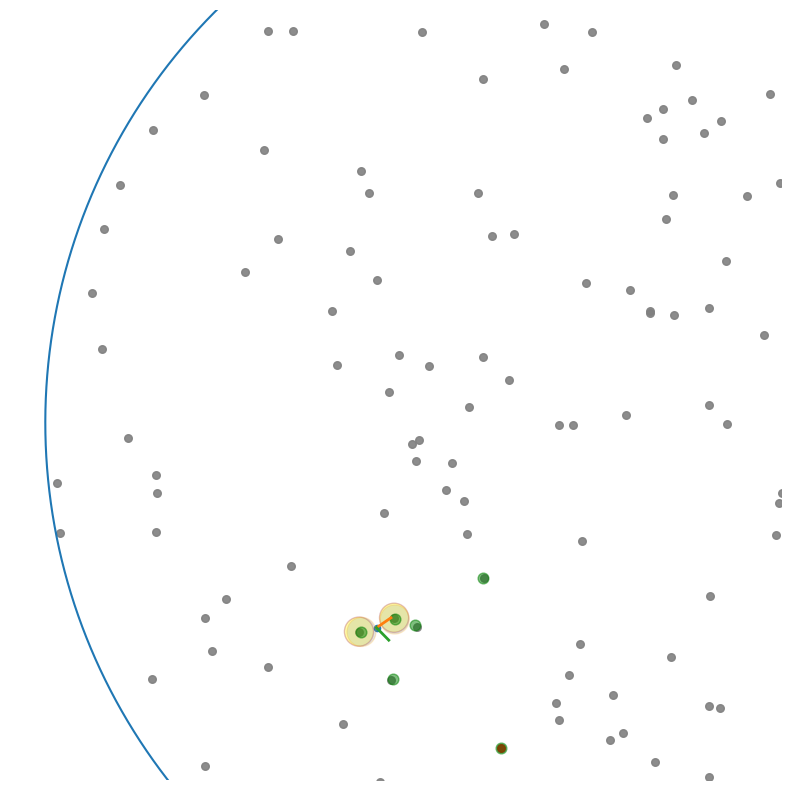

In [5]:
log_dir = "SB3_data/SB3_Aug_11/"
retrieve_dir = "SB3_data/SB3_Aug_11/"
retrieve_buffer = False
n_steps = 1000



class CollectInformation(MultiFF):  # Note when using this wrapper, the number of steps cannot exceed one episode
  def __init__(self):
      super().__init__()
      self.ff_information = np.ones([self.num_ff, 8])*(-9999)   #[index, x, y, time_start, time_captured, mx(when_captured), my(when_captured), index_in_flash]

  def reset(self):
      self.obs = super().reset()
      self.ff_information[:,0] = np.arange(self.num_ff)
      self.ff_information[:,7] = np.arange(self.num_ff)
      self.ff_information[:,1] = self.ffx.numpy()
      self.ff_information[:,2] = self.ffy.numpy()
      self.ff_information[:,3] = 0
      return self.obs

  def calculate_reward(self):
      reward = super().calculate_reward()
      if self.num_targets > 0:
        for index in self.captured_ff_index:
          overall_index = int(self.ff_information[:,0][np.where(self.ff_information[:,-1]==index)[0][-1]])
          self.ff_information[overall_index, 4] = self.time
          self.ff_information[overall_index, 5] = self.agentx.item()
          self.ff_information[overall_index, 6] = self.agenty.item()
        self.new_ff_info = np.ones([self.num_targets, 8])*(-9999)
        self.new_ff_info[:,0] = np.arange(len(self.ff_information), len(self.ff_information)+self.num_targets)
        self.new_ff_info[:,7] = np.array(self.captured_ff_index)
        self.new_ff_info[:,1] = self.ffx[self.captured_ff_index].numpy()
        self.new_ff_info[:,2] = self.ffy[self.captured_ff_index].numpy()
        self.new_ff_info[:,3] = self.time
        self.ff_information = np.concatenate([self.ff_information, self.new_ff_info], axis = 0)
      return(reward)

# def reset_wrapper(self):
env = CollectInformation()

# Create and wrap the environment
os.makedirs(log_dir, exist_ok=True)

env = Monitor(env, log_dir)
env.reset()

env.flash_on_interval = 0.3
env.distance2center_cost = 0

# For direct training
sac_model = SAC("MlpPolicy",
                env,
                gamma=0.995,
                learning_rate=0.0015,
                batch_size=1024,
                target_update_interval=50,
                buffer_size=1000000,
                learning_starts=10000,
                train_freq=10,
                ent_coef=0.00083,
                policy_kwargs=dict(activation_fn=nn.Tanh, net_arch=[128, 128])
                )

path = os.path.join(retrieve_dir, 'best_model.zip')
sac_model = sac_model.load(path, env=env)
if retrieve_buffer == True:
    path2 = os.path.join(retrieve_dir, 'buffer.pkl')
    sac_model.load_replay_buffer(path2)

# Test the trained agent
obs = env.reset()
cum_rewards = 0
mx = []
my = []
mheading = []  # in radians
ffxy_all = []
ffxy_visible = []
ffxy2_all = []
time_rl = []
mx_rewarded = []
my_rewarded = []
reward_log = []
captured_ff = []
num_targets = []
env_obs = []
visible_ff_indices_all = []
memory_ff_indices_all = []
monkey_t = []
monkey_speed = []
obs_ff_indices_all = []
obs_ff_overall_indices_all = []
memory_all = []
ff_angles2 = []
ff_distances2 = []
all_captured_ff_x = []
all_captured_ff_y = []
for step in range(n_steps):
    action, _ = sac_model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    cum_rewards += reward
    previous_ffxy = env.ffxy
    prev_ff_information = env.ff_information.copy()
    obs, reward, done, info = env.step(action)
    reward_log.append(reward)
    num_targets.append(env.num_targets)
    memory_all.append(env.ff_memory_all)
    if env.num_targets > 0:
        captured_ff.append(env.captured_ff_index)
        all_captured_ff_x = all_captured_ff_x + previous_ffxy[env.captured_ff_index][:, 0].tolist()
        all_captured_ff_y = all_captured_ff_y + previous_ffxy[env.captured_ff_index][:, 1].tolist()
    else:
        captured_ff.append(0)
    mx.append(env.agentx.item())
    my.append(env.agenty.item())
    monkey_t.append(env.time)
    monkey_speed.append(env.dv.item())
    mheading.append(env.agentheading.item())
    time_rl.append(env.time)
    ffxy_all.append(env.ffxy.clone())
    ffxy2_all.append(env.ffxy2.clone())
    ffxy_visible.append(env.ffxy[env.visible_ff_indices].clone())
    env_obs.append(obs)
    visible_ff_indices_all.append(env.visible_ff_indices)
    memory_ff_indices_all.append(env.ff_in_memory_indices)
    obs_ff_indices_all.append(env.topk_indices)
    real_indices = []
    for index in env.topk_indices:
        real_indices.append(
            int(prev_ff_information[:, 0][np.where(prev_ff_information[:, 7] == index.item())[0][-1]].copy()))
    obs_ff_overall_indices_all.append(real_indices)
    if len(env.topk_indices) > 0:
        ff_angles2.append(env.ff_angle_topk_2)
        ff_distances2.append(env.ff_distance_topk)
    else:
        ff_angles2.append(torch.tensor([]))
        ff_distances2.append(torch.tensor([]))
    if done:
        obs = env.reset()







## Animation

# base_number = 100
# series = base_number + 10
# filename = f"Demo{series + 1}"

start = 100
num_frame = 200
arena_radius = 1000
invisible_distance = 250
global fig;
fig = plt.figure(dpi=100)
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 15
colors_YlGn = plt.get_cmap("YlGn")(np.linspace(0, 1, 101))
# colors_RdPu = plt.get_cmap("RdPu")(np.linspace(0,1,101))
circle_theta = np.arange(0, 2 * pi, 0.01)
circle_x = np.cos(circle_theta) * arena_radius
circle_y = np.sin(circle_theta) * arena_radius
fig, ax = plt.subplots()
cum_mx, cum_my = mx[start:start + num_frame], my[start:start + num_frame]
xmin, xmax = np.min(cum_mx), np.max(cum_mx)
ymin, ymax = np.min(cum_my), np.max(cum_my)
ax.set_xlim((xmin - invisible_distance, xmax + invisible_distance))
ax.set_ylim((ymin - invisible_distance, ymax + invisible_distance))
ax.set_aspect('equal')


def animate(j):
    ax.cla()
    ax.axis('off')
    ax.plot(circle_x, circle_y)
    i = j + start
    ax.scatter(mx[start:i + 1], my[start:i + 1], s=20)
    ax.scatter(ffxy_all[i].T[0], ffxy_all[i].T[1], alpha=0.9, c="gray", s=30)
    # Plot the reward boundaries of the circles

    for k in obs_ff_indices_all[i]:
        circle = plt.Circle((ffxy_all[i][k][0], ffxy_all[i][k][1]), 25, facecolor='yellow', edgecolor='brown',
                            alpha=0.3, zorder=1)
        ax.add_patch(circle)
        if memory_all[i][k] < 20:
            circle = plt.Circle((ffxy2_all[i][k][0], ffxy2_all[i][k][1]), 25, facecolor='grey', edgecolor='orange',
                                alpha=0.2, zorder=1)
            ax.add_patch(circle)

    ax.plot(np.array([mx[i], mx[i] + 30 * np.cos(mheading[i] + 2 * pi / 9)]),
            np.array([my[i], my[i] + 30 * np.sin(mheading[i] + 2 * pi / 9)]), linewidth=2)
    ax.plot(np.array([mx[i], mx[i] + 30 * np.cos(mheading[i] - 2 * pi / 9)]),
            np.array([my[i], my[i] + 30 * np.sin(mheading[i] - 2 * pi / 9)]), linewidth=2)

    # for k in memory_ff_indices_all[i]:
    #   if k in obs_ff_indices_all[i]:
    #     circle = plt.Circle((ffxy_all[i][k][0], ffxy_all[i][k][1]), 25, facecolor='yellow', edgecolor='orange', alpha=0.3, zorder=1)
    #     ax.add_patch(circle)
    #   else:
    #     circle = plt.Circle((ffxy_all[i][k][0], ffxy_all[i][k][1]), 25, facecolor='grey', edgecolor='orange', alpha=0.3, zorder=1)
    #     ax.add_patch(circle)

    if torch.numel(ffxy_visible[i]) > 0:
        ax.scatter(ffxy_visible[i].T[0], ffxy_visible[i].T[1], alpha=0.9, c="red", s=30)

    # Plot position of ffs with uncertainties
    ax.scatter(ffxy2_all[i][memory_ff_indices_all[i]].T[0], ffxy2_all[i][memory_ff_indices_all[i]].T[1], s=60,
               alpha=0.5, color="green")

    # Plot ff positions recovered from relative angle and distance
    ##if torch.numel(ffx_recovered) > 0:
    ##  ffy_recovered = torch.sin(ff_angles2[i]+mheading[i]) * ff_distances2[i] + my[i]
    ##  ax.scatter(ffx_recovered.clone(), ffy_recovered.clone(), alpha=0.9, c="black", s=30)

    # Plot captured fireflies
    if num_targets[i] > 0:
        # ax.scatter(ffxy_all[i-1][captured_ff[i]].T[0], ffxy_all[i-1][captured_ff[i]].T[1], s=70, alpha=0.7, color="purple")
        # captured_ff_cum_x = captured_ff_cum_x+ffxy_all[i-1][captured_ff[i]].T[0].tolist()
        # captured_ff_cum_y = captured_ff_cum_y+ffxy_all[i-1][captured_ff[i]].T[1].tolist()
        # if len(captured_ff_cum_x) >0:
        ax.scatter(ffxy_all[i - 1][captured_ff[i]].T[0], ffxy_all[i - 1][captured_ff[i]].T[1], s=70, alpha=0.7,
                   color="purple")
    ax.set_xlim((xmin - invisible_distance, xmax + invisible_distance))
    ax.set_ylim((ymin - invisible_distance, ymax + invisible_distance))
    ax.set_aspect('equal')

    # annotation = f"angle: {round(env_obs[i][0].item(), 2)}"
    # annotation = f"angle: {round(action_reward[i][0].item(), 2)}"
    # ax.text(0.78, 0.95, annotation, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=12, color="black", bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


anim = animation.FuncAnimation(fig, animate,
                               frames=num_frame, interval=100, repeat=True)

#
# # gif_dir = ''
# # os.makedirs(gif_dir, exist_ok=True)
# # anim.save(f"{gif_dir}/{filename}.gif", writer='pillow', fps=60)
# # writervideo = animation.FFMpegWriter(fps=4)  # original = 10
# # anim.save(f"{gif_dir}/{filename}.mp4", writer=writervideo)
#

anim
print("done")